# Prediction of Heart Disease
We are building a model to predict whether or not a patient with certain characteristics has heart disease.  

## Setup and Exploratory Data Analysis

In [1815]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
import warnings

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

Let's load the data and have a look.  

In [1816]:
df = pd.read_csv("heart.csv")
df.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [1817]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [1818]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,918.0,53.510893,9.432617,28.0,47.00,54.0,60.0,77.0
RestingBP,918.0,132.396514,18.514154,0.0,120.00,130.0,140.0,200.0
Cholesterol,918.0,198.799564,109.384145,0.0,173.25,223.0,267.0,603.0
FastingBS,918.0,0.233115,0.423046,0.0,0.00,0.0,0.0,1.0
MaxHR,918.0,136.809368,25.460334,60.0,120.00,138.0,156.0,202.0
Oldpeak,918.0,0.887364,1.066570,-2.6,0.00,0.6,1.5,6.2
HeartDisease,918.0,0.553377,0.497414,0.0,0.00,1.0,1.0,1.0


Notice how both RestingBP and Cholesterol have 0 values?  These must be missing values and will need to be handled before passing to our model. 

In [1819]:
df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [1820]:
df.duplicated().sum()

np.int64(0)

In [1821]:
df.HeartDisease.value_counts()

HeartDisease
1    508
0    410
Name: count, dtype: int64

Let's examine some correlations with our dependent variable.  

In [1822]:
df.corrwith(df.HeartDisease, numeric_only=True)

Age             0.282039
RestingBP       0.107589
Cholesterol    -0.232741
FastingBS       0.267291
MaxHR          -0.400421
Oldpeak         0.403951
HeartDisease    1.000000
dtype: float64

Interestingly, Cholesterol is negatively correlated with HeartDisease, which doesn't follow.  Perhaps after we clean the zero values this correlation will reverse?  

## Data Visualization

In [1823]:
sns.set_theme()

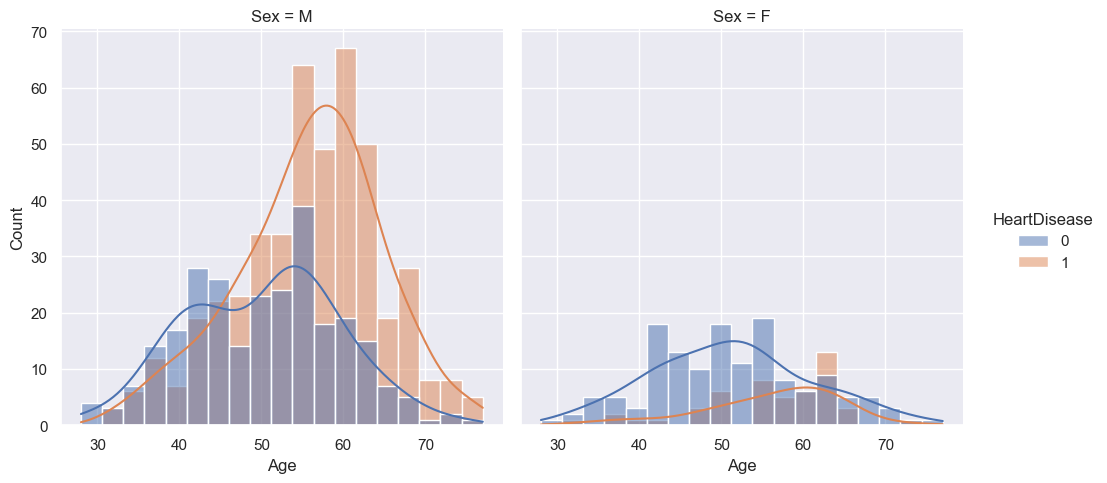

In [1824]:
sns.displot(data=df, x="Age", hue="HeartDisease", col="Sex", kde=True)
plt.show()

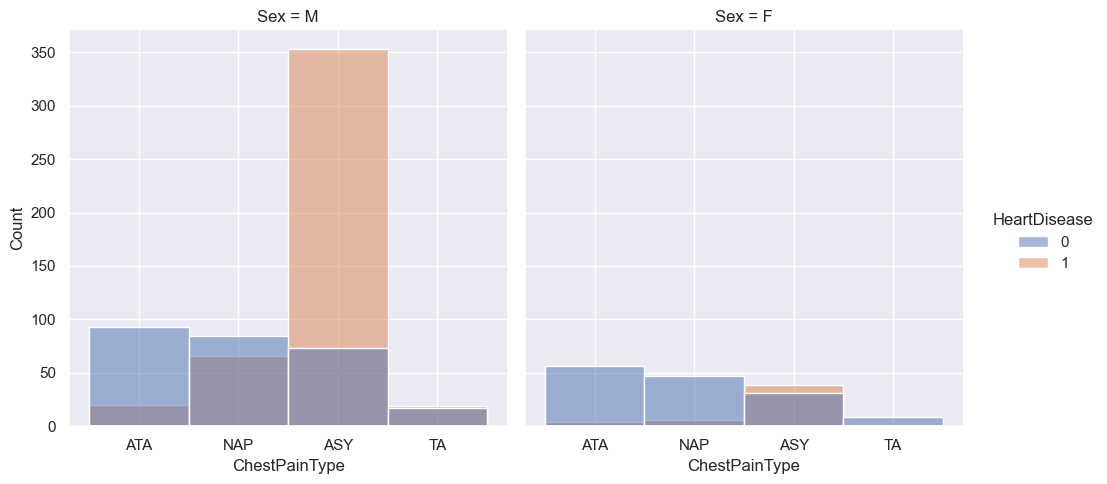

In [1825]:
sns.displot(data=df, x="ChestPainType", hue="HeartDisease", col="Sex")
plt.show()

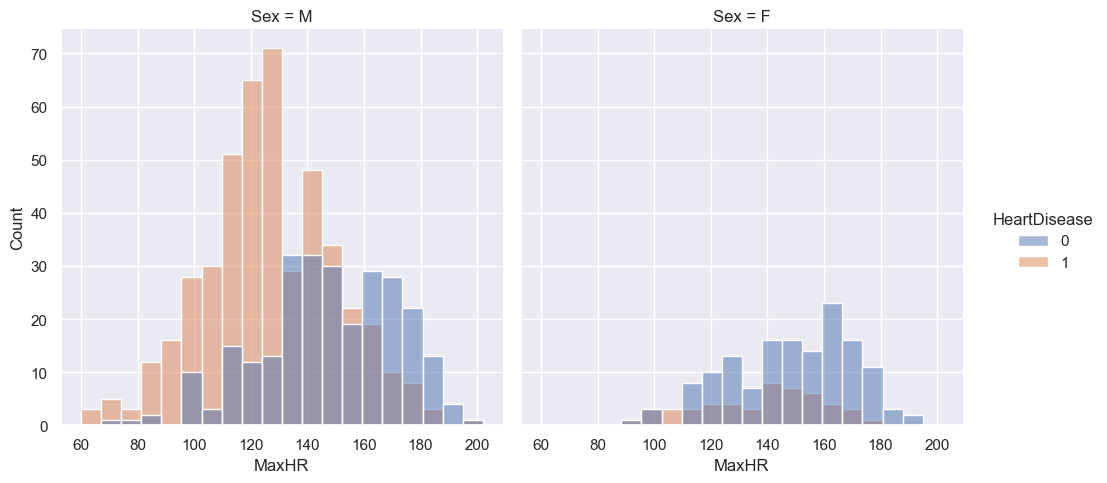

In [1826]:
sns.displot(data=df, x="MaxHR", hue="HeartDisease", col="Sex")
plt.show()

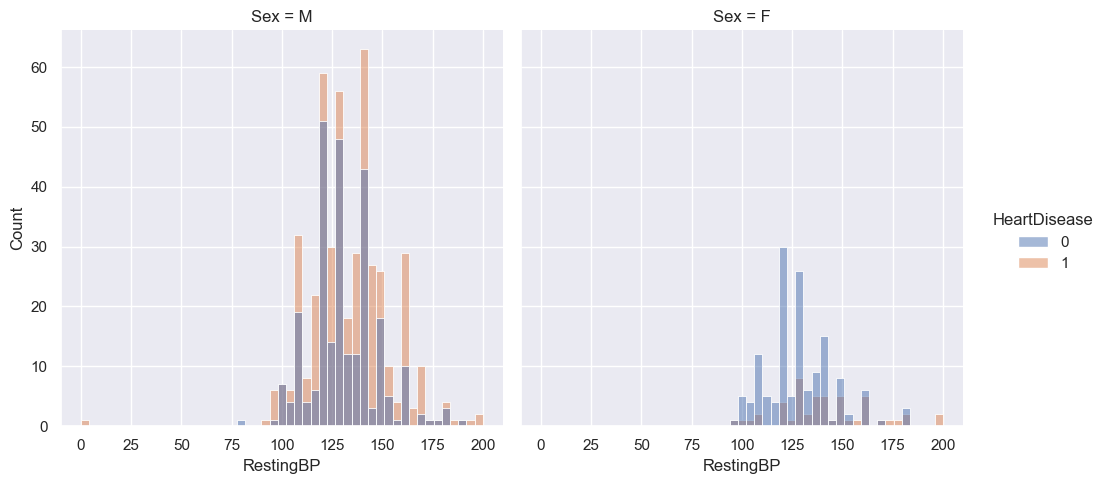

In [1827]:
sns.displot(data=df, x="RestingBP", hue="HeartDisease", col="Sex")
plt.show()

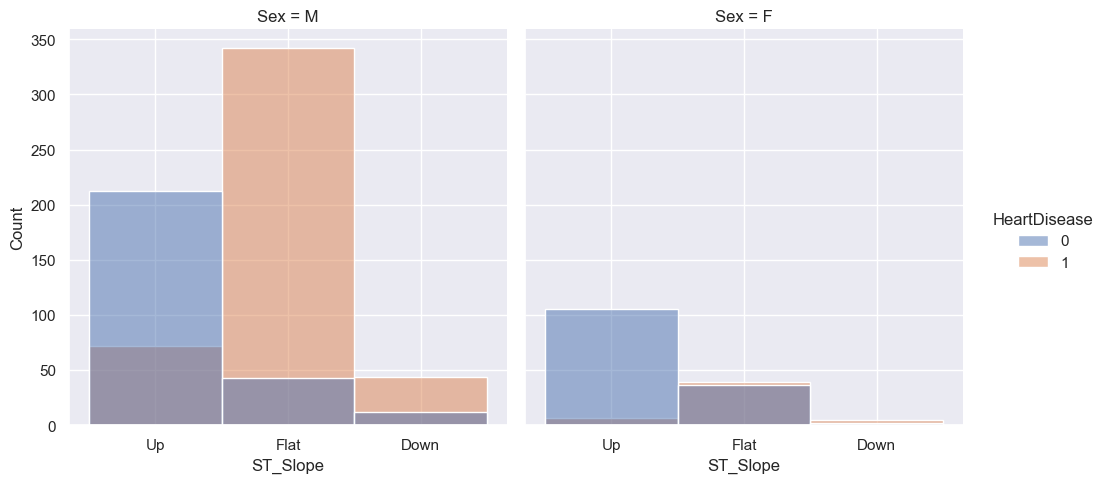

In [1828]:
sns.displot(data=df, x="ST_Slope", hue="HeartDisease", col="Sex")
plt.show()

In [1829]:
# sns.pairplot(data=df, hue="HeartDisease")
# plt.show()

## Data Preprocessing

Let's split our data into dependent/independent training/testing sets.  

In [1830]:
X = df.drop("HeartDisease", axis=1)
y = df.HeartDisease
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0, stratify=y)

Let's list the categorical features and their possible values.  

In [1831]:
for cat_feature in X_train.select_dtypes(include="object"):
    print(f"Feature: {cat_feature}, Values: {X_train[cat_feature].unique()}")

Feature: Sex, Values: ['M' 'F']
Feature: ChestPainType, Values: ['ATA' 'ASY' 'NAP' 'TA']
Feature: RestingECG, Values: ['Normal' 'ST' 'LVH']
Feature: ExerciseAngina, Values: ['N' 'Y']
Feature: ST_Slope, Values: ['Up' 'Flat' 'Down']


These are all categorical nominal features, so we'll need to use one-hot encoding before modelling. We will also get rid of those peksy 0 values by replacing them with an average.  We could also drop all of these rows, but it would be a shame to lose this many records with otherwise good data.  

In [1832]:
# imputer = SimpleImputer(missing_values = 0, strategy="mean")
imputer = KNNImputer(missing_values=0, n_neighbors=5)
cat_features = df.select_dtypes(include="object").columns.to_list()
oh_encoder = OneHotEncoder(handle_unknown="ignore", drop="first")
ct = ColumnTransformer([
    ("impute_cholesterol", imputer, ["Cholesterol"]),
    ("impute_restingbp", imputer, ["RestingBP"]),
    ("1he", oh_encoder, cat_features)
    ], remainder="passthrough")

## Model Selection and Evaluation

Now we will run a few different classifiers and get some cross-validated scores.  Although our data is balanced on the dependent variable, there are some strong negative reprecussions for false negatives (i.e. heart disease goes untreated and people die).  For this reason, we will be using F1 scoring, which takes into account not just accuracy, but also precision and recall.  

In [1833]:
scaler = StandardScaler()
pipe_svc = Pipeline([
    ("ct", ct),
    ("scaler", scaler),
    ("svc", SVC(random_state=0))
])
pipe_lr = Pipeline([
    ("ct", ct),
    ("scaler", scaler),
    ("lr", LogisticRegression(random_state=0)) 
])
pipe_knn = Pipeline([
    ("ct", ct),
    ("scaler", scaler),
    ("knn", KNeighborsClassifier()) 
])
pipe_rf = Pipeline([
    ("ct", ct),
    ("scaler", scaler),
    ("rf", RandomForestClassifier(random_state=0)) 
])
pipe_nb = Pipeline([
    ("ct", ct),
    ("scaler", scaler),
    ("gnb", GaussianNB())
])

pipes = [pipe_svc, pipe_lr, pipe_knn, pipe_rf, pipe_nb]
score_table = [["Classifier", "Average Score", "Standard Deviation"]]
for pipe in pipes:
    # pipe.fit(X_train, y_train)
    scores = cross_val_score(pipe, X_train, y_train, cv=5, scoring="f1")
    score_table.append([pipe[-1], scores.mean(), scores.std()])

scores_df = pd.DataFrame(score_table)
scores_df.columns = scores_df.iloc[0]
scores_df = scores_df.iloc[1:]
print(scores_df.to_string(index=False))


                            Classifier Average Score Standard Deviation
                   SVC(random_state=0)       0.87757           0.029062
    LogisticRegression(random_state=0)      0.862587           0.017188
                KNeighborsClassifier()      0.867577           0.018084
RandomForestClassifier(random_state=0)      0.887221           0.030353
                          GaussianNB()      0.868734           0.029425


Although they all perform pretty well, the Random Forest Classifier has an edge.  Let's do some hyperparameter tuning to see if we can improve the predictive power.  

In [ ]:
params = [{"rf__n_estimators": [50, 100, 150], 
           "rf__max_depth": [3, 5, 7, 10, None],
           "rf__min_samples_split": [2, 5, 10],
           "rf__min_samples_leaf": [1, 2, 4],
           "rf__max_features": [0.5, 1, "sqrt", "log2", "auto", None],
           }]

grid_search = RandomizedSearchCV(estimator=pipe_rf, n_jobs=-1, cv=5, param_distributions=params, scoring="f1", n_iter=100, random_state=0)
grid_search.fit(X_train, y_train)
best_score = grid_search.best_score_
best_params = grid_search.best_params_
print(f"Best Score: {best_score:.3f}, Best Parameters: {best_params}")


In [ ]:
rf_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5, scoring="f1")
print(f"F1 Score: {rf_scores.mean():.3f}, Standard Deviation: {rf_scores.std():.3f}")

F1 Score: 0.892, Standard Deviation: 0.023


Finally, let's evaluate the model's performance against our test set.  

In [1811]:
y_pred = grid_search.best_estimator_.predict(X_test)
print(f"F1 Score: {f1_score(y_test, y_pred):.3f}")

F1 Score: 0.880


Looks good, close to the results on our training set. Let's see which features are most important to our Random Forest model.   

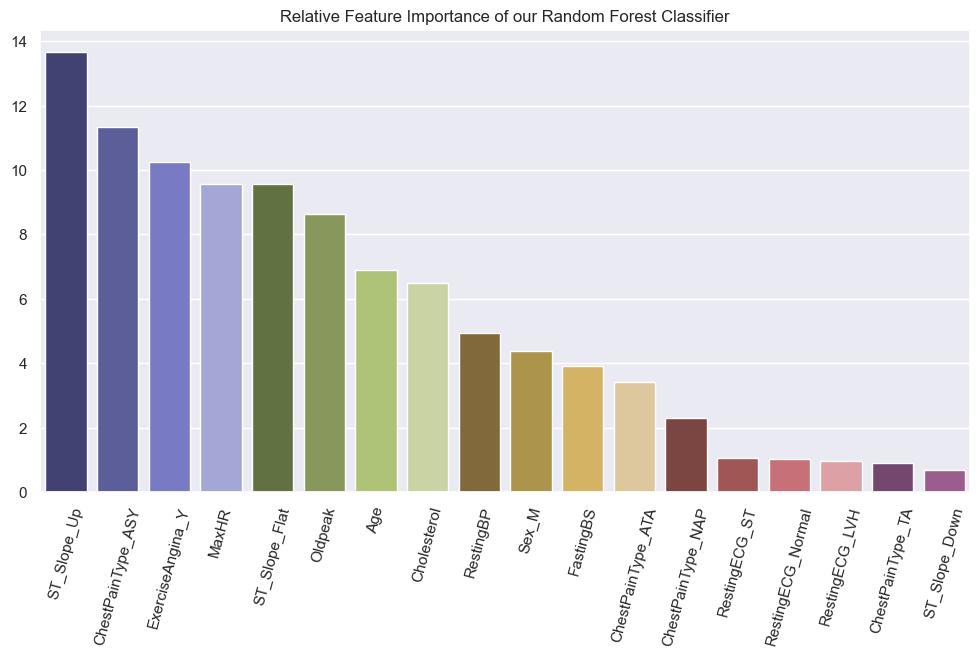

In [1812]:
model = grid_search.best_estimator_
importances = model[-1].feature_importances_
labels = model["ct"].get_feature_names_out()
labels_no_prefix = [l.split("__")[1] for l in labels]
indices = np.argsort(-importances)
importances_dict = {}
for i in indices:
    importances_dict[labels_no_prefix[i]] = importances[i]
df_importances = pd.DataFrame(importances_dict, index=[0]) 
plt.figure(figsize=(12, 6))
ax = sns.barplot(df_importances*100, palette="tab20b")
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
ax.set_title("Relative Feature Importance of our Random Forest Classifier")
plt.show()

In [1813]:
print(classification_report(y_test, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.837     0.878     0.857        82
           1      0.898     0.863     0.880       102

    accuracy                          0.870       184
   macro avg      0.868     0.870     0.869       184
weighted avg      0.871     0.870     0.870       184



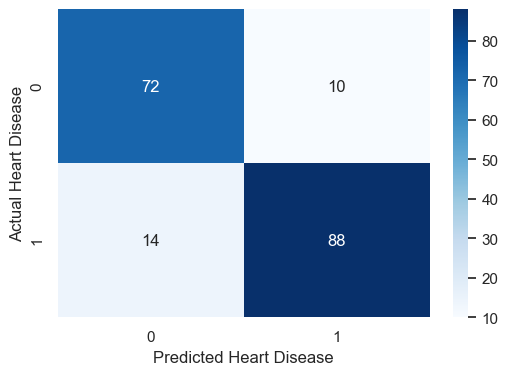

In [ ]:
c_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(pd.DataFrame(c_matrix), annot=True, cmap="Blues")
plt.xlabel("Predicted Heart Disease")
plt.ylabel("Actual Heart Disease")
plt.show()